# Examples: `discrete` 

In [1]:
import importlib
import sys
sys.path.append('..')

from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
from scipy import interpolate

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
n = 6
k = int(1e5)
X = np.zeros((1, n))

state = np.random.RandomState(1950)
_Sigma = np.identity(n)
for i in range(n):
    for j in range(i):
        _Sigma[i, j] = _Sigma[j, i] = state.uniform(-0.2, 0.2)
X = np.vstack([X, state.multivariate_normal(np.zeros(n), _Sigma, size=k)])
for _ in range(4):
    scale = state.uniform(0.5, 1.5, size=n)
    loc = state.uniform(-3.0, 3.0, size=n)
    X = np.vstack([X, state.normal(loc=loc, scale=scale, size=(k, n))])
X = X - np.mean(X, axis=0)

In [4]:
dims = ["x", "px", "y", "py", "z", "pz"]

## 2D plotting

In [5]:
axis = (0, 1)
_X = ps.discrete.downsample(X[:, axis], 1000)
_dims = [dims[k] for k in axis]

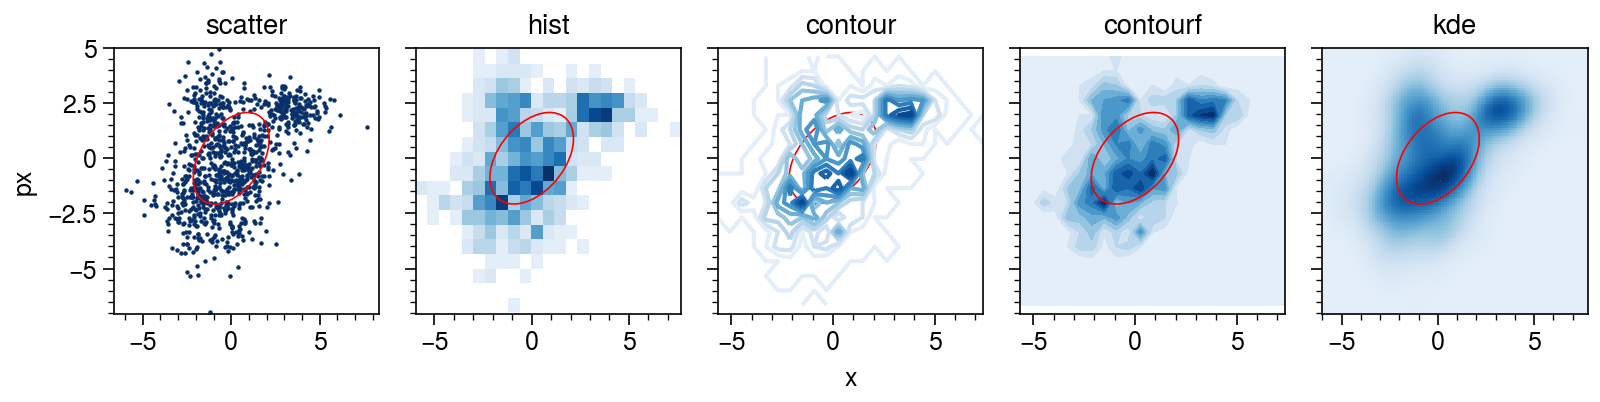

In [6]:
# cmap = pplt.Colormap('purples', left=0.05, right=1.0)
cmap = pplt.Colormap('blues', left=0.1)
kinds = ['scatter', 'hist', 'contour', 'contourf', 'kde']

fig, axs = pplt.subplots(ncols=len(kinds), figwidth=8.0)
for ax, kind in zip(axs, kinds):
    kws = dict()
    if kind == 'scatter':
        kws['c'] = cmap(1.0)
    else:
        kws['cmap'] = cmap
    psv.discrete.plot2d(
        _X, ax=ax, kind=kind,
        rms_ellipse=True, 
        rms_ellipse_kws=dict(color='red'),
        **kws
    )
    ax.format(title=kind)
axs.format(xlabel=_dims[0], ylabel=_dims[1])

### Enclosing sphere/ellipsoid 

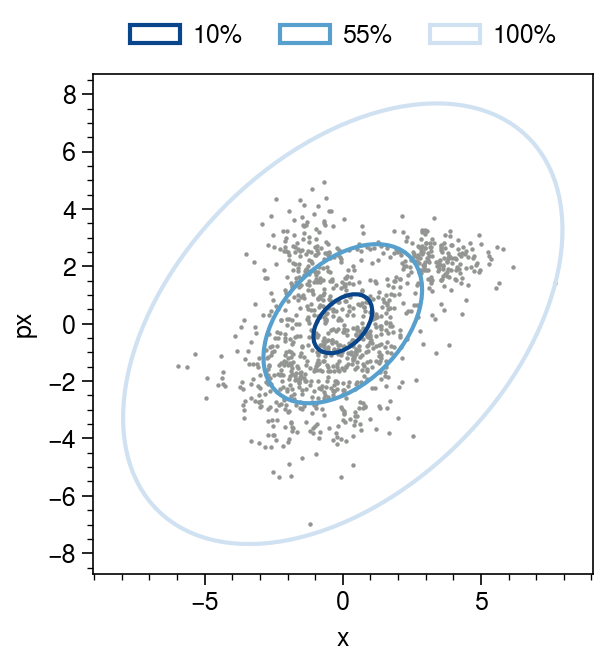

In [7]:
fig, ax = pplt.subplots()
psv.discrete.plot2d(_X, ax=ax, kind='scatter', c='grey')

fractions = np.linspace(0.10, 1.0, 3)
cmap = pplt.Colormap('blues', left=0.2, reverse=True)
for fraction in fractions:
    level = ps.discrete.enclosing_ellipsoid(_X, fraction=fraction)
    psv.discrete.plot_rms_ellipse(
        _X, ax=ax, level=level, 
        color=cmap(fraction), 
        lw=1.5,
        label=f'{(100.0 * fraction):.0f}%',
    )
ax.legend(loc='t', ncols=3, framealpha=0)
ax.format(xlabel=_dims[0], ylabel=_dims[1])
plt.show()

### Spherical and ellipsoidal shell slices 

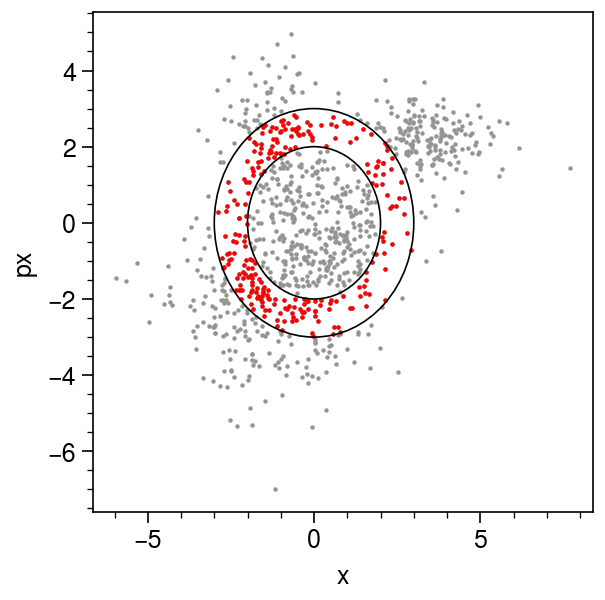

In [8]:
rmin = 2.0
rmax = 3.0
_X1 = ps.discrete.slice_sphere(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.discrete.plot2d(_X, ax=ax, kind='scatter', c='grey')
psv.discrete.plot2d(_X1, ax=ax, kind='scatter', c='red')
for r in [rmin, rmax]:
    psv.circle(r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

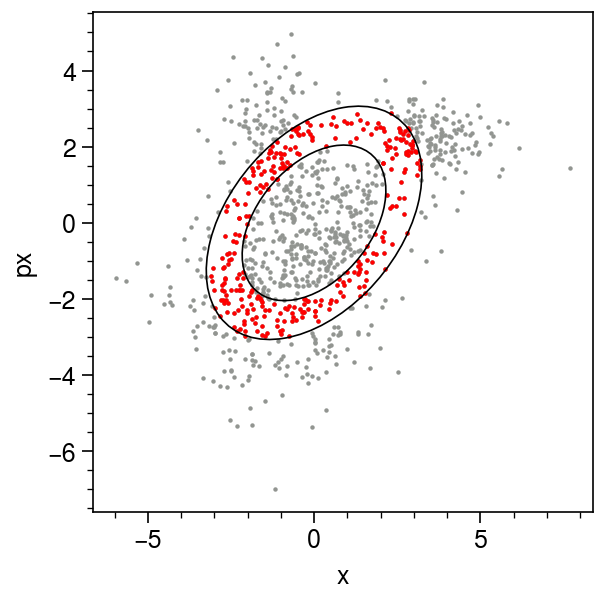

In [9]:
rmin = 1.0
rmax = 1.5
_X1 = ps.discrete.slice_ellipsoid(_X, rmin=rmin, rmax=rmax)

fig, ax = pplt.subplots()
psv.discrete.plot2d(_X, ax=ax, kind='scatter', c='grey')
psv.discrete.plot2d(_X1, ax=ax, kind='scatter', c='red')
for r in [rmin, rmax]:
    psv.discrete.plot_rms_ellipse(X, level=r, ax=ax)
ax.format(xlabel=_dims[0], ylabel=_dims[1])

In [10]:
@interact(rmin=(0.0, 3.0))
def update(rmin):
    @interact(rmax=(rmin, 5.0))
    def update2(rmax):
        _X1 = ps.discrete.slice_ellipsoid(_X, axis=(0, 1), rmin=rmin, rmax=rmax)

        fig, ax = pplt.subplots()
        xmax = 10.0
        ax.format(xlim=(-xmax, xmax), ylim=(-xmax, xmax))
        psv.discrete.plot2d(_X, ax=ax, kind='scatter', c='grey')
        psv.discrete.plot2d(_X1, ax=ax, kind='scatter', c='red')
        for r in [rmin, rmax]:
            psv.discrete.plot_rms_ellipse(X, level=r, ax=ax)
        ax.format(xlabel=_dims[0], ylabel=_dims[1])
        plt.show()

interactive(children=(FloatSlider(value=1.5, description='rmin', max=3.0), Output()), _dom_classes=('widget-in…

### Contour shell slice

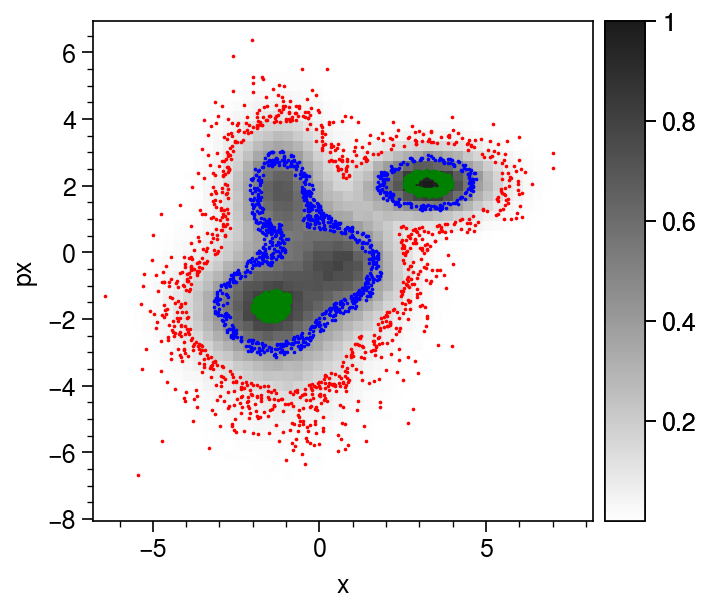

In [11]:
bins = 50
Y = X[:, axis]

fig, ax = pplt.subplots()
psv.discrete.plot2d(
    Y, ax=ax, kind='hist', 
    cmap=pplt.Colormap('mono', left=0.0, right=0.9),
    discrete=False,
    process_kws=dict(norm='max'),
    return_mesh=True,
    colorbar=True,
    bins=bins,
)
for lmin, c in zip([0.0, 0.4, 0.8], ['red', 'blue', 'green']):
    lmax = lmin + 0.15
    Y1 = ps.discrete.slice_contour(Y, lmin=lmin, lmax=lmax, bins=bins)
    psv.discrete.plot2d(
        ps.discrete.downsample(Y1, 1000), 
        ax=ax, kind='scatter', c=c, s=0.5,
    )
ax.format(xlabel=_dims[0], ylabel=_dims[1])
plt.show()

## Corner plot 

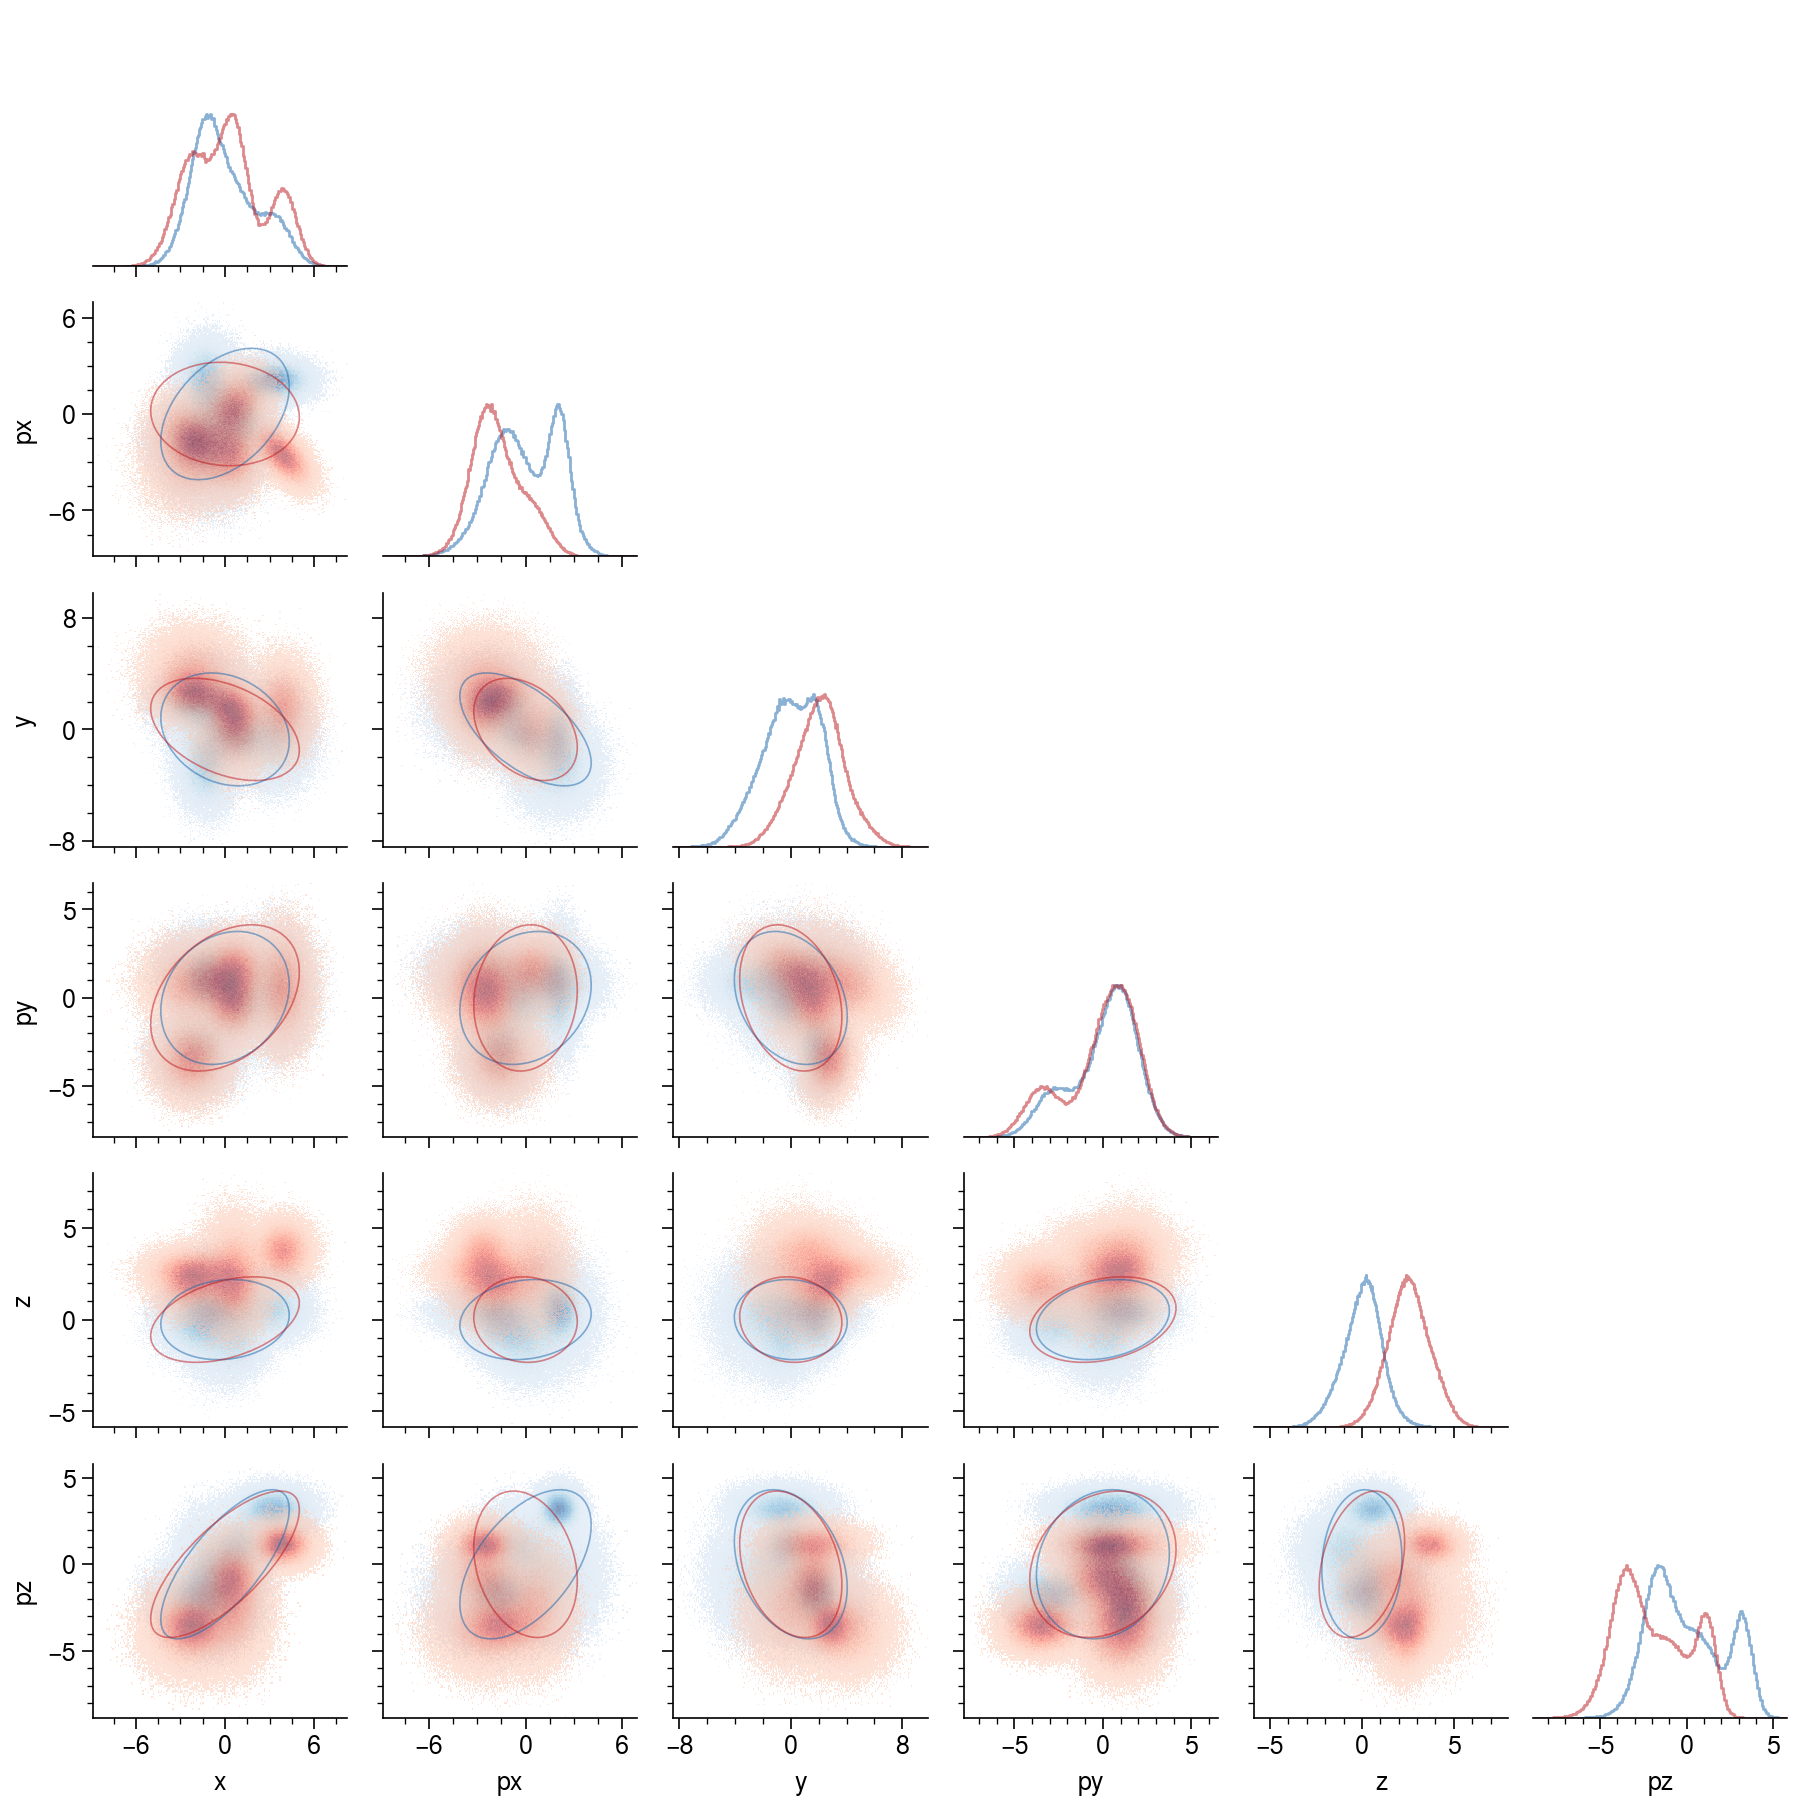

In [12]:
alpha = 0.5
cmaps = [pplt.Colormap(name, left=0.2) for name in ['blues', 'reds']]
diag_colors = [cmap(0.75) for cmap in cmaps]
diag_kind = 'step'

axs = psv.discrete.corner(
    X, 
    kind='hist',
    diag=True,
    labels=dims,
    diag_kws=dict(color=diag_colors[0], alpha=alpha),
    bins='auto',
    rms_ellipse=True,
    rms_ellipse_kws=dict(level=2.0, color=diag_colors[0], alpha=0.5),
    cmap=cmaps[0],
    alpha=alpha,
    mask=True,
)

R = ps.ap.phase_adv_matrix(np.radians(45.0), np.radians(20.0), np.radians(10.0))
axes = psv.discrete.corner(
    ps.discrete.transform_linear(X, R) + state.uniform(-3.0, 3.0, size=(1, X.shape[1])),
    axs=axs,
    diag_kws=dict(color=diag_colors[1], alpha=alpha),
    autolim_kws=dict(),
    cmap=cmaps[1],
    alpha=alpha,
    rms_ellipse=True,
    rms_ellipse_kws=dict(level=2.0, color=diag_colors[1], alpha=0.5),
)

## Interactive slicing

In [13]:
kws = dict(
    profx=True, profy=True,
    prof_kws=dict(color='white'),
    process_kws=dict(norm='max'),
    mask=False,
)
psv.discrete.plot2d_interactive_slice(X, dims=dims, **kws)

interactive(children=(Checkbox(value=False, description='log'), Checkbox(value=True, description='auto plot re…